In [1]:
import glob
import os
from collections import Counter
from itertools import combinations, product

import numpy as np
np.random.seed(18012023)

import pandas as pd
pd.set_option('display.max_colwidth', 0)

import seaborn as sb

from sklearn.metrics import pairwise_distances
import lxml.etree
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, \
                            precision_recall_curve, average_precision_score, \
                            roc_auc_score
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'Arial'
from IPython.display import display

This notebook covers some additional experiments which were eventually not reported in the paper. I keep the code here for the sake of future reference. In essence, this notebook compares all texts with one another and uses the intertext retrieval to identify longer borrowings across texts. While many such borrowings were successfully detected, all of these had already been reported in the literature however, so new findings were made.

## Load (meta)data

In [2]:
meta_df = pd.read_excel('../data/metadata_corrected.xlsx')
meta_df = meta_df[meta_df['exclude'] != 'x']
meta_df.sample(10)

,id,title,author,provenance,date_range,genre,subgenre,exclude
267,van_smeinscen_lede,Van smeinscen lede,NaN,cdrom-mnl,1300-1400,Epiek,Didactiek,NaN
63,florigout_fragm_l,Florigout,NaN,cdrom-mnl,1375-1400,Epiek,Ridder,NaN
111,loyhier_en_malaert_fragm_a,Loyhier en Malaert,NaN,cdrom-mnl,1350-1400,Epiek,Karel,NaN
86,historie_van_gaver_capeel,Historie van Gaver Capeel,NaN,cdrom-mnl,1500-1520,Epiek,Ridder,NaN
168,renout_van_montalbaen_fragm_l,Renout van Montalbaen,NaN,cdrom-mnl,1300-1400,Epiek,Karel,NaN
215,spiegel_historiael__1_3_4_maerlant,Spiegel historiael (P1-P4),Jacob van Maerlant,cdrom-mnl,1300-1325,Epiek,Historiografie,NaN
211,spiegel_der_sonden,Spiegel der sonden,NaN,cdrom-mnl,1440-1460,Epiek,Didactiek,NaN
123,madelgijs_fragm_d,Madelgijs,NaN,cdrom-mnl,1340-1360,Epiek,Karel,NaN
166,Reinout van Montalbaen,Reinout van Montalbaen,NaN,CG1,1300-1276,Epiek,Karel,NaN
240,theophilus,Theophilus,NaN,cdrom-mnl,1400-1420,Epiek,Heiligenleven,NaN


In [3]:
def get_verse_groups(verses, size=2, intertexts=False):
    for i in range(len(verses) - (size - 1)):
        if not intertexts:
            yield ' / '.join(verses[i : i + size])
        else:
            its = Counter(verses[i : i + size])
            if None in its:
                yield None
            elif len(its) > 1:
                yield 'overlap'
            else:
                yield list(its.keys())[0]

In [4]:
def parse_xml(fn, rm_interpol=False):
    try:
        tree = lxml.etree.parse(fn)
    except OSError:
        print(f'- Could not load {fn}')
        return None
        
    if rm_interpol:
        for interpolation in tree.xpath("//interpolation"):
            interpolation.getparent().remove(interpolation)
        
    for line_node in tree.iterfind('.//l'):
        try:
            intertext_id = line_node.attrib['intertext']
        except KeyError:
            intertext_id = None
        
        tokens_ = line_node.attrib['tokens'].split()
        lemmas_ = []
        
        lemma_tags = [l.text for l in line_node.iterfind('.//lemma')]
        pos_tags = [p.text for p in line_node.iterfind('.//pos')]
        
        for lemma, pos in zip(lemma_tags, pos_tags):
            for l, p in zip(lemma.split('+'), pos.split('+')):
                    if p == 'n(prop)':
                        lemmas_.append('n(prop)')
                    else:
                        lemmas_.append(l)
    
        yield tokens_, lemmas_, intertext_id

In [5]:
GROUP_SIZE = 2

titles, tokens, lemmas, intertexts = [], [], [], []

for title, group in tqdm(meta_df.groupby('title')):
    work_tokens, work_lemmas, work_intertexts = [], [], []
    
    for id_ in sorted(group['id']):
        for tok, lem, intertext_id in parse_xml(f'../data/xml/{id_}.xml'):
            work_tokens.append(tok)
            work_lemmas.append(lem)
            work_intertexts.append(intertext_id)
    
    verse_tokens = [' '.join(v) for v in work_tokens]
    verse_lemmas = [' '.join(v) for v in work_lemmas]

    verse_group_tokens = list(get_verse_groups(verse_tokens, size=GROUP_SIZE))
    verse_group_lemmas = list(get_verse_groups(verse_lemmas, size=GROUP_SIZE))
    verse_group_intertexts = list(get_verse_groups(work_intertexts, size=GROUP_SIZE, intertexts=True))

    tokens.extend(verse_group_tokens)
    lemmas.extend(verse_group_lemmas)
    intertexts.extend(verse_group_intertexts)
    titles.extend([title] * len(verse_group_lemmas))

100%|██████████| 205/205 [00:15<00:00, 13.11it/s]


In [6]:
df = pd.DataFrame(zip(titles, tokens, lemmas, intertexts), columns=('title', 'tokens', 'lemmas', 'intertext'))
df = df[df['intertext'] != 'overlap']

In [7]:
def add_rhyme_column(df):
    rhyme_words = []
    for lemmas in df['lemmas']:
        rhymes = []
        for verse in lemmas.split(' / '):
            rhymes.append(verse.strip().split()[-1])
        rhyme_words.append(' '.join(rhymes))
    df['rhyme'] = rhyme_words
    return df

df = add_rhyme_column(df)

In [8]:
optim_vs = 7000
optim_rw = 0.1693877551020408
optim_th = 0.42202047865566794
rolling_size = 1000

In [9]:
def tokenizer(text):
    return text.replace(' / ', ' ').lower().strip().split()

vec = TfidfVectorizer(max_features=optim_vs, min_df=2,
                      tokenizer=tokenizer, token_pattern=None).fit(df['lemmas'])

## Case studies: macro-level

#### Utility functions

In [10]:
def batch(iterable, n=1):
    l = iterable.shape[0]
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def pairwise(title1, title2, rhyme_weight=.25, batch_size=5000):
    
    A = df[df['title'] == title1]
    B = df[df['title'] == title2]

    AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])

    all_distances = None

    for ax in batch(AX, batch_size):
        if all_distances is None:
            all_distances = pairwise_distances(ax, BX, metric='cosine')
        else:
            all_distances = np.append(all_distances,
                                      pairwise_distances(ax, BX, metric='cosine'),
                                      axis=0)
    
    return all_distances

In [11]:
def plot_min_distance_nn(t1, t2, min_dists, threshold, rolling_size=1000):
    mu = min_dists.rolling(rolling_size).mean()
    fig, ax = plt.subplots()
    mu.plot(ax=ax)
    ax.axhline(threshold, ls='--', c='grey')
    ax.set_ylim(0, 1)
    ax.set_xlabel(t1)
    ax.set_ylabel('Distance to NN in ' + t2)
    return ax

In [12]:
def get_interpolations(title):
    fn = meta_df[meta_df['title'] == title]['id'].iloc[0]
    tree = lxml.etree.parse(f'../data/xml/{fn}.xml').getroot()
    interpol_idxs, interpol_names, line_cnt = [], [], 0
    for element in tree:
        line_cnt += 1
        if element.tag == 'interpolation':
            idxs, length = line_cnt, len(element.findall('l'))
            interpol_idxs.append([line_cnt, line_cnt + length])
            line_cnt += length
            interpol_names.append(element.attrib['reason'])      
    return interpol_idxs, interpol_names

#### Case studies

Heelu in de Vijfde Partie:

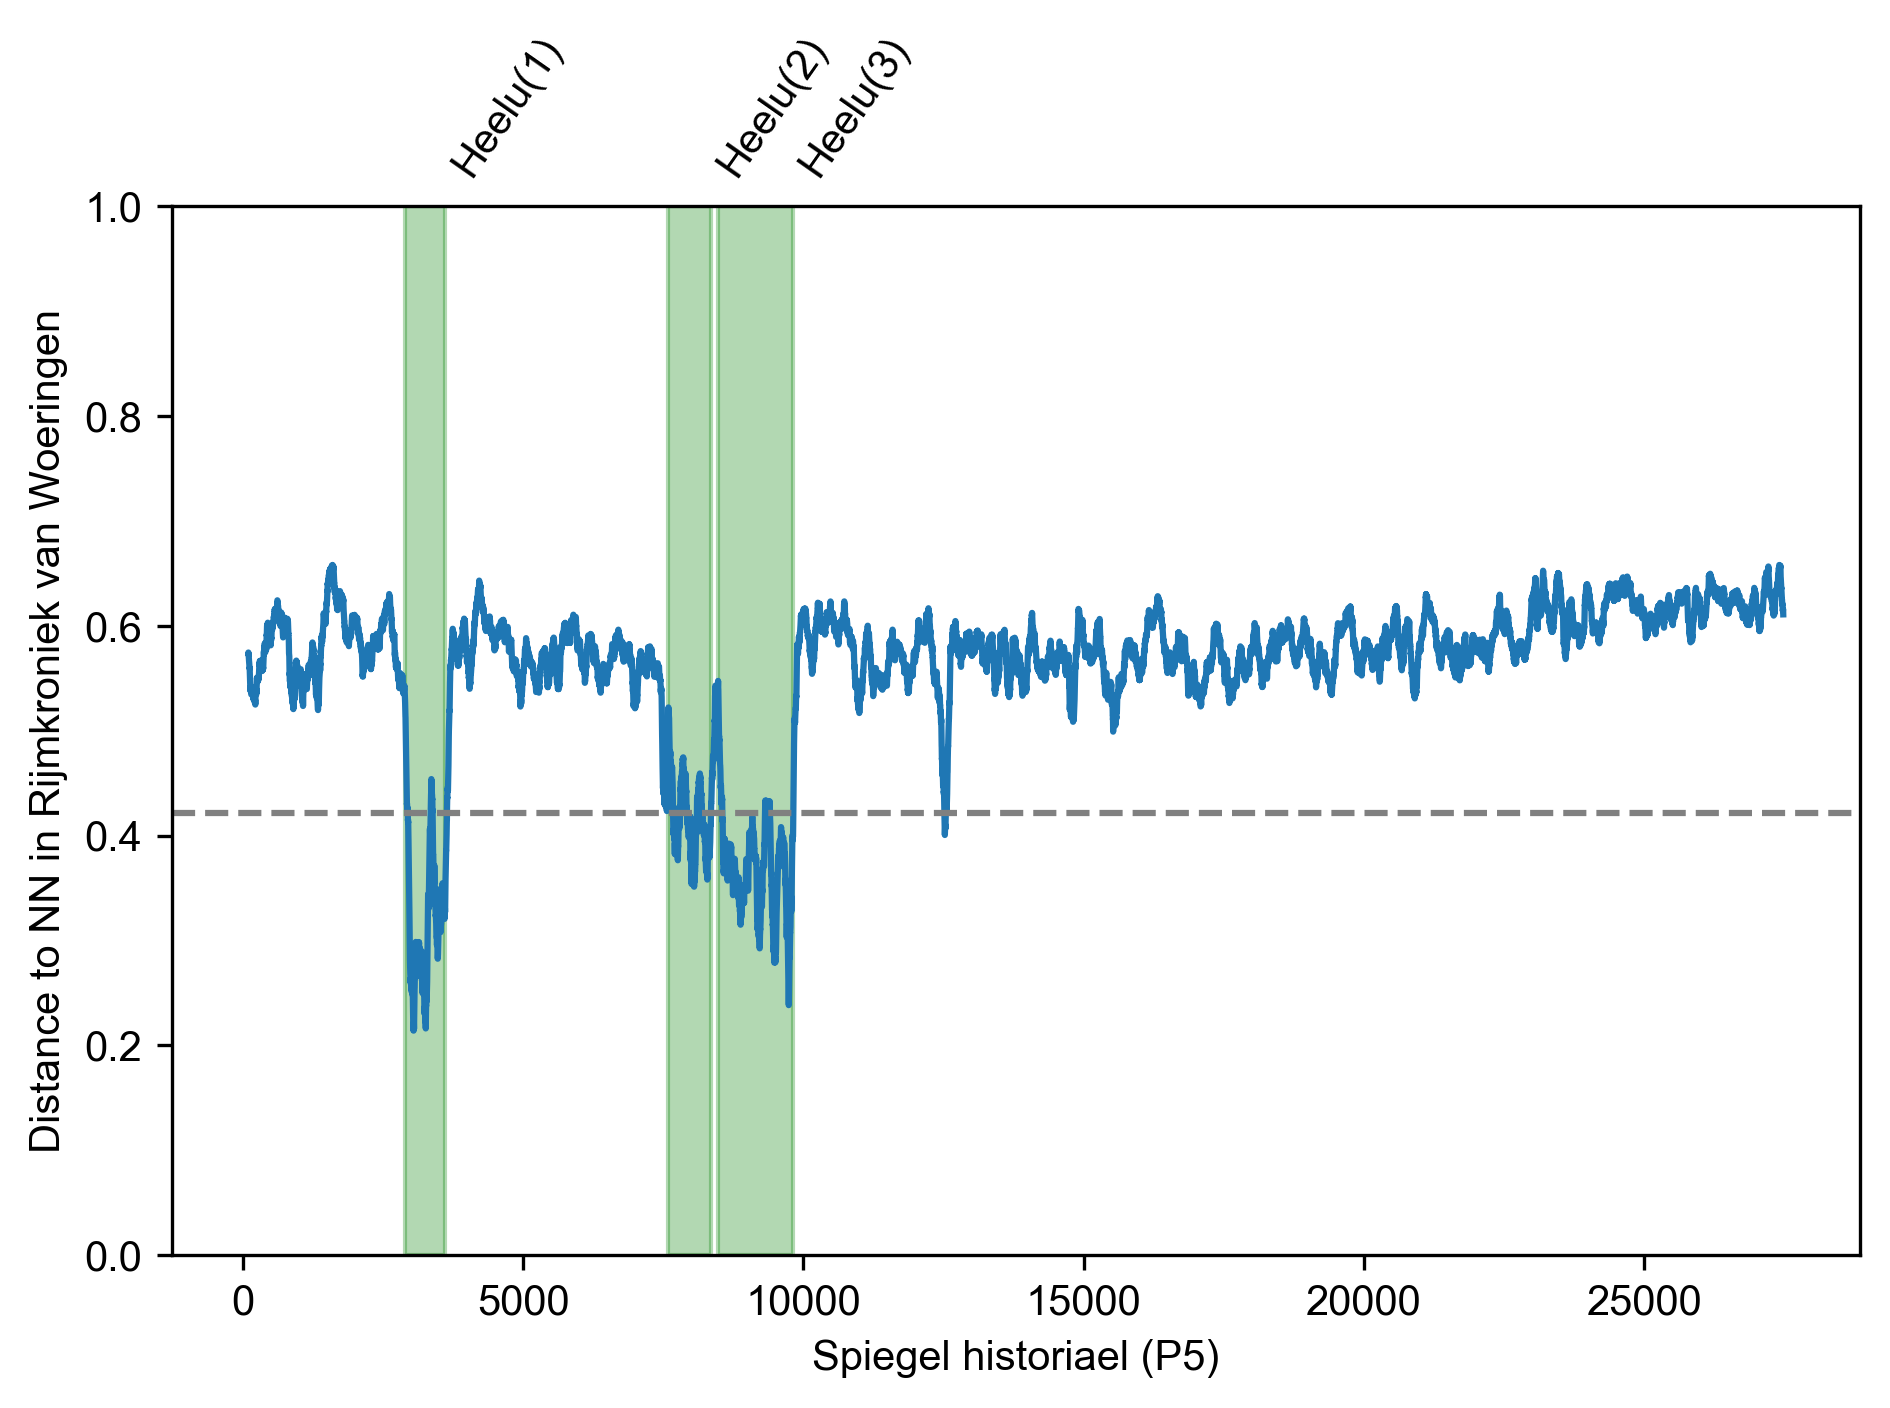

In [13]:
t1, t2 = 'Spiegel historiael (P5)', 'Rijmkroniek van Woeringen'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=optim_th, rolling_size=100)
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    if n.startswith('Heelu'):
        ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
        plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()

Maerlant in de Brabantse yeesten:

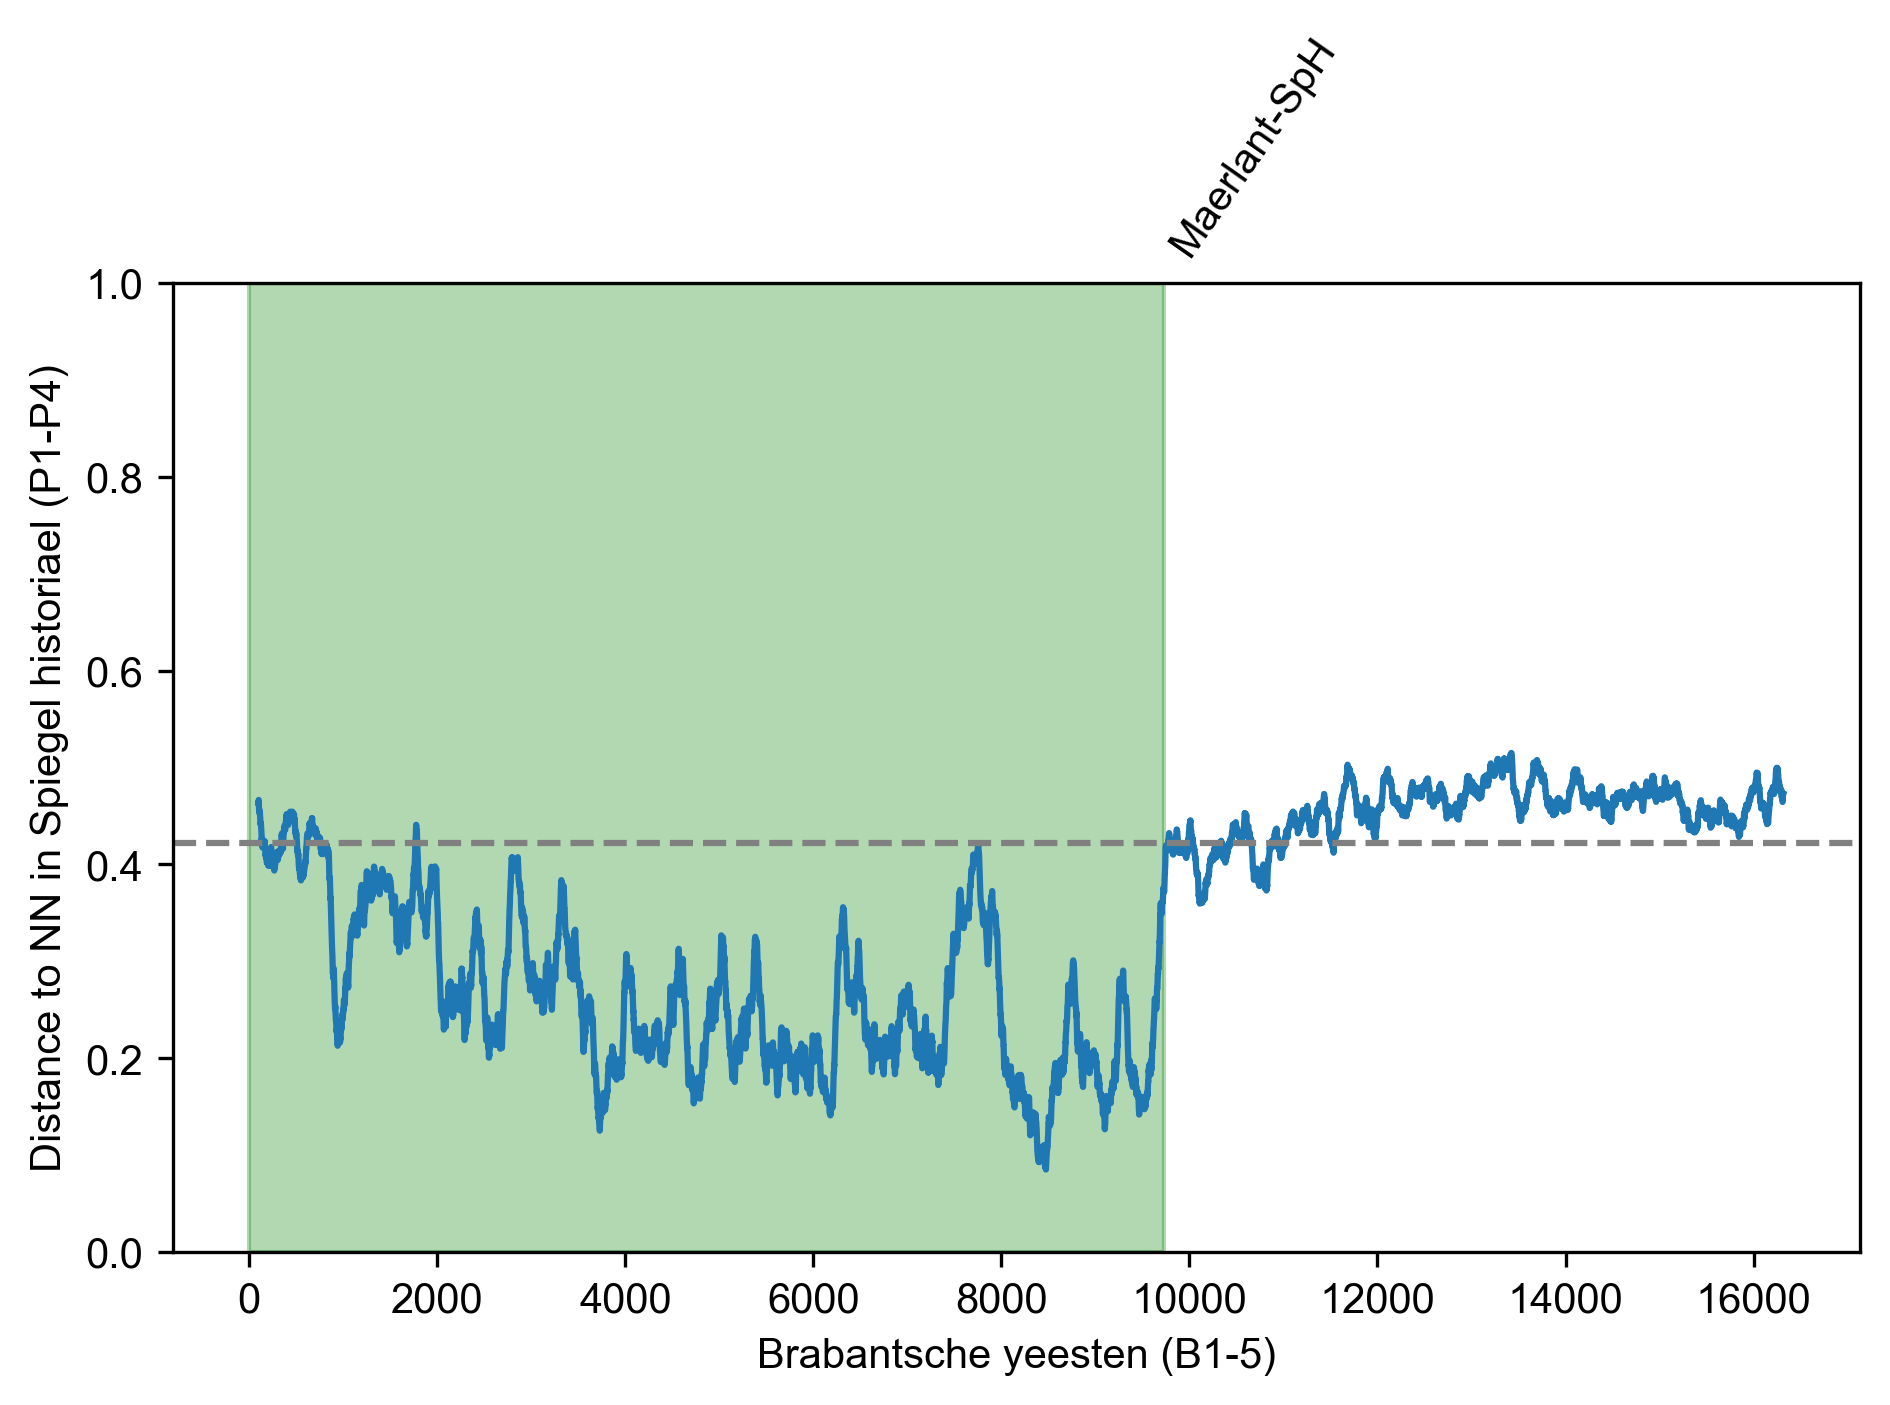

In [14]:
t1, t2 = 'Brabantsche yeesten (B1-5)', 'Spiegel historiael (P1-P4)'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=optim_th, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
    plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()

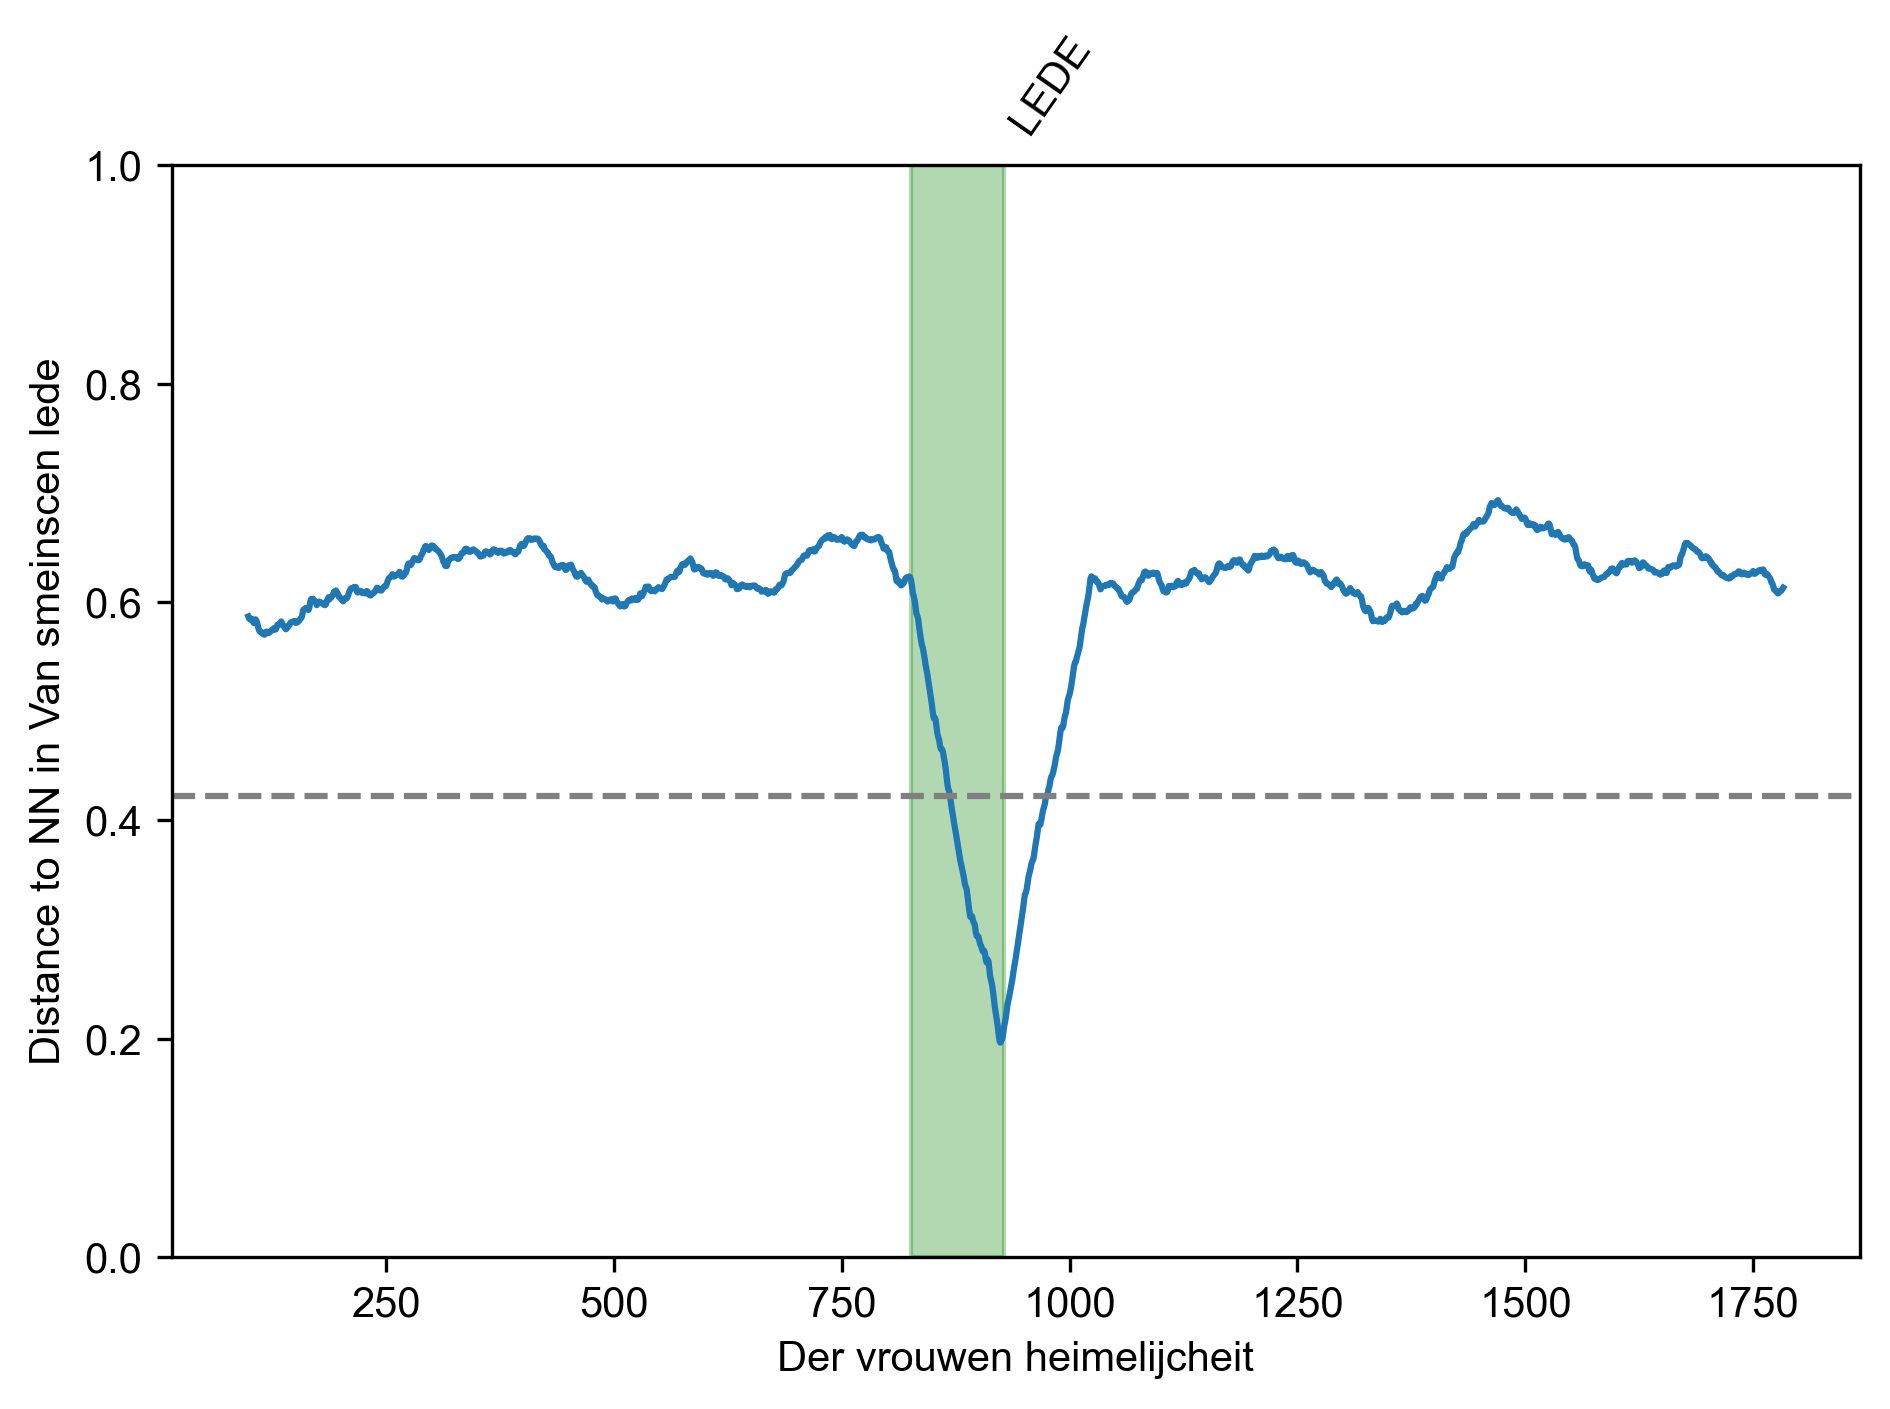

In [15]:
t1, t2 = 'Der vrouwen heimelijcheit', 'Van smeinscen lede'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=optim_th, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
    plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()

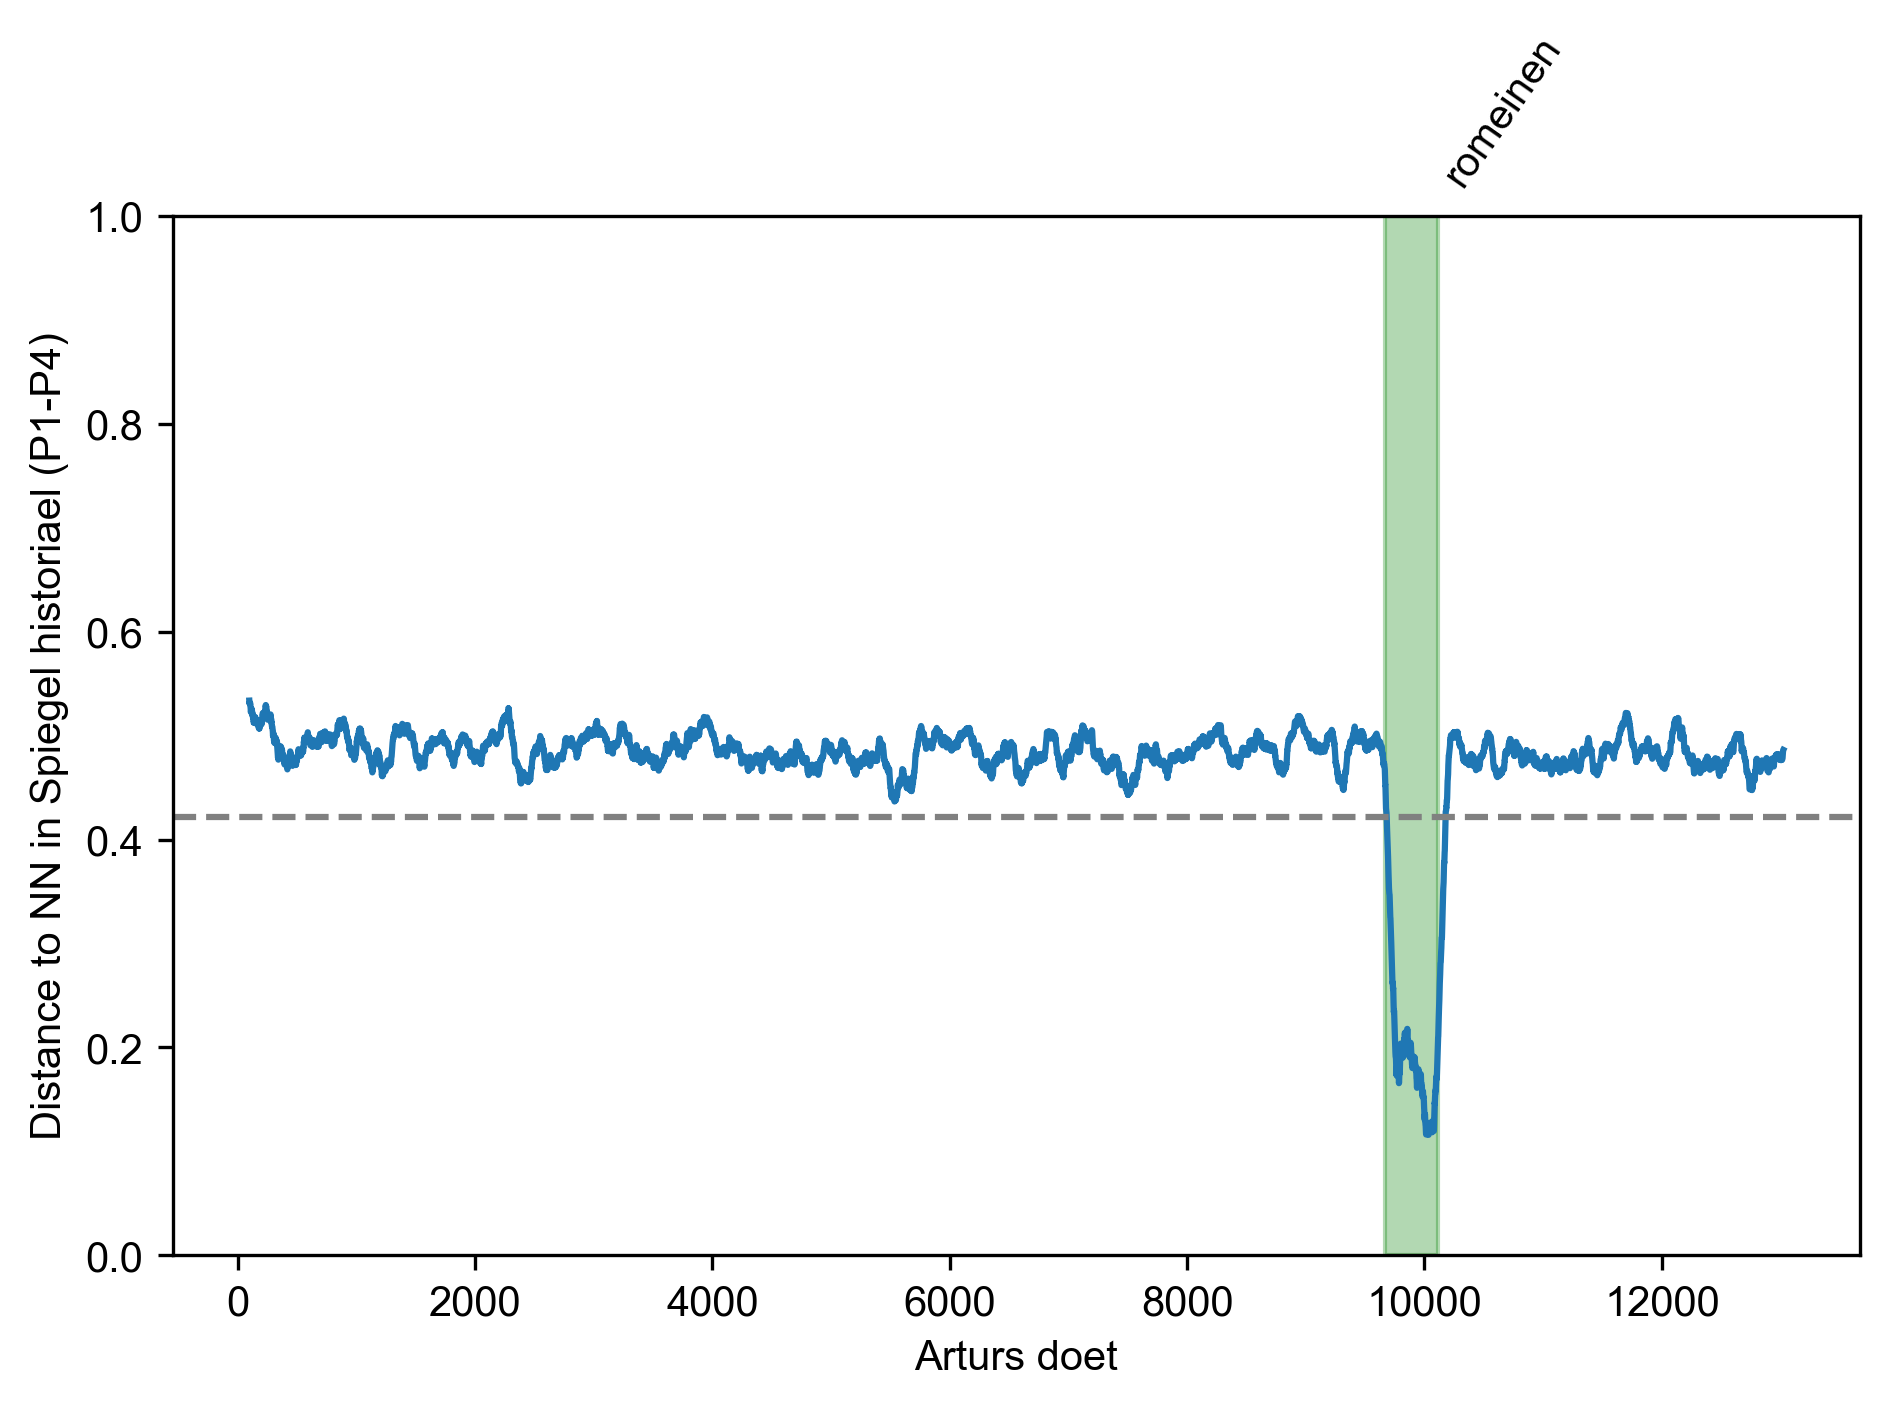

In [16]:
t1, t2 = 'Arturs doet', 'Spiegel historiael (P1-P4)'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=optim_th, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    if not 'gebed' in n:
        ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
        plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()

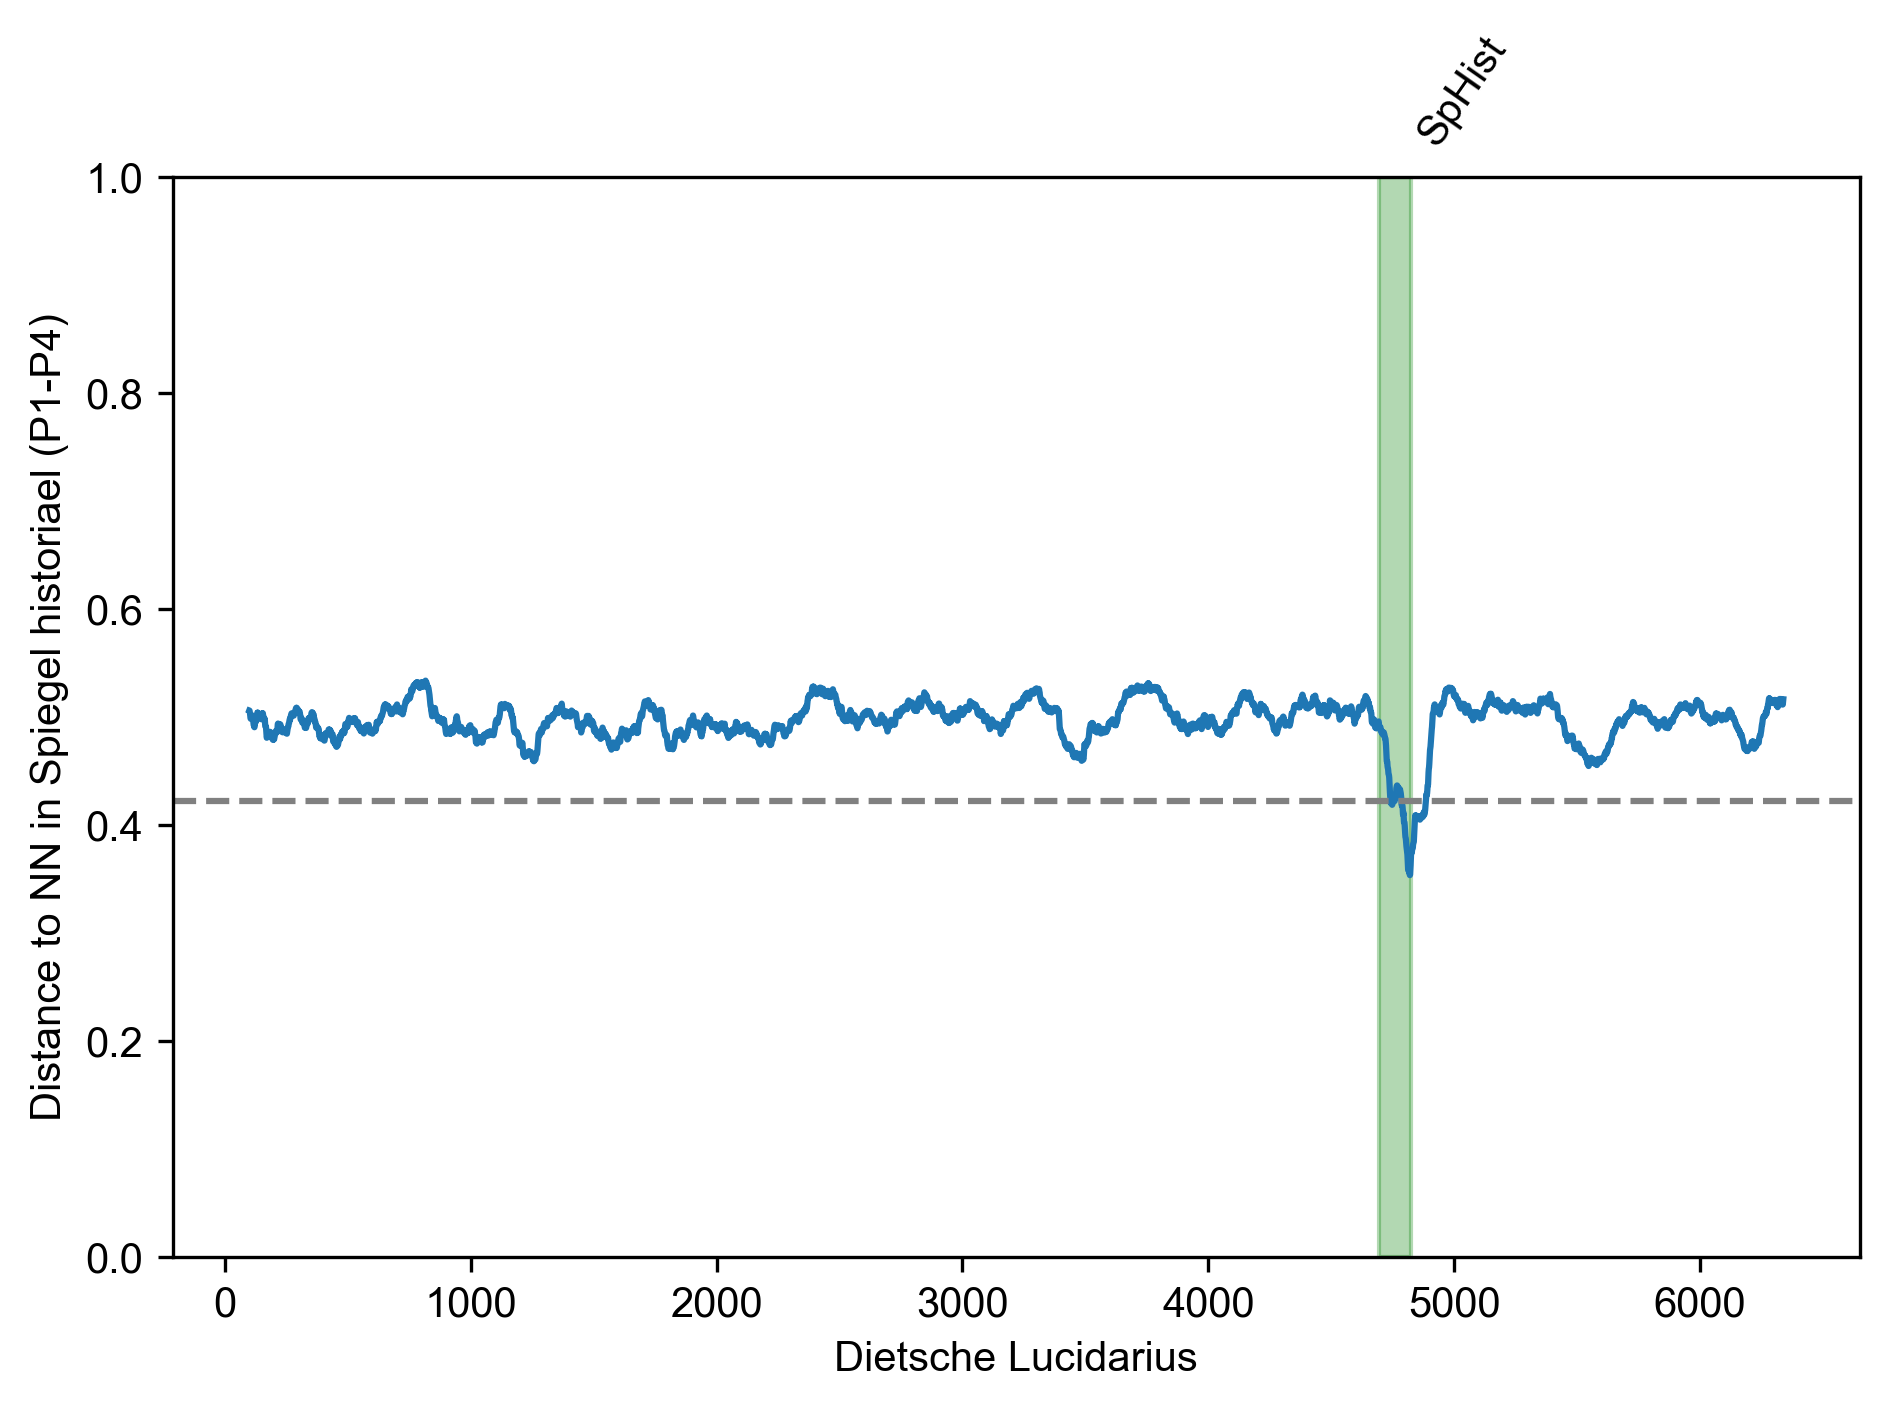

In [17]:
t1, t2 = 'Dietsche Lucidarius', 'Spiegel historiael (P1-P4)'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=optim_th, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    if 'SpHist' in n:
        ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
        plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()

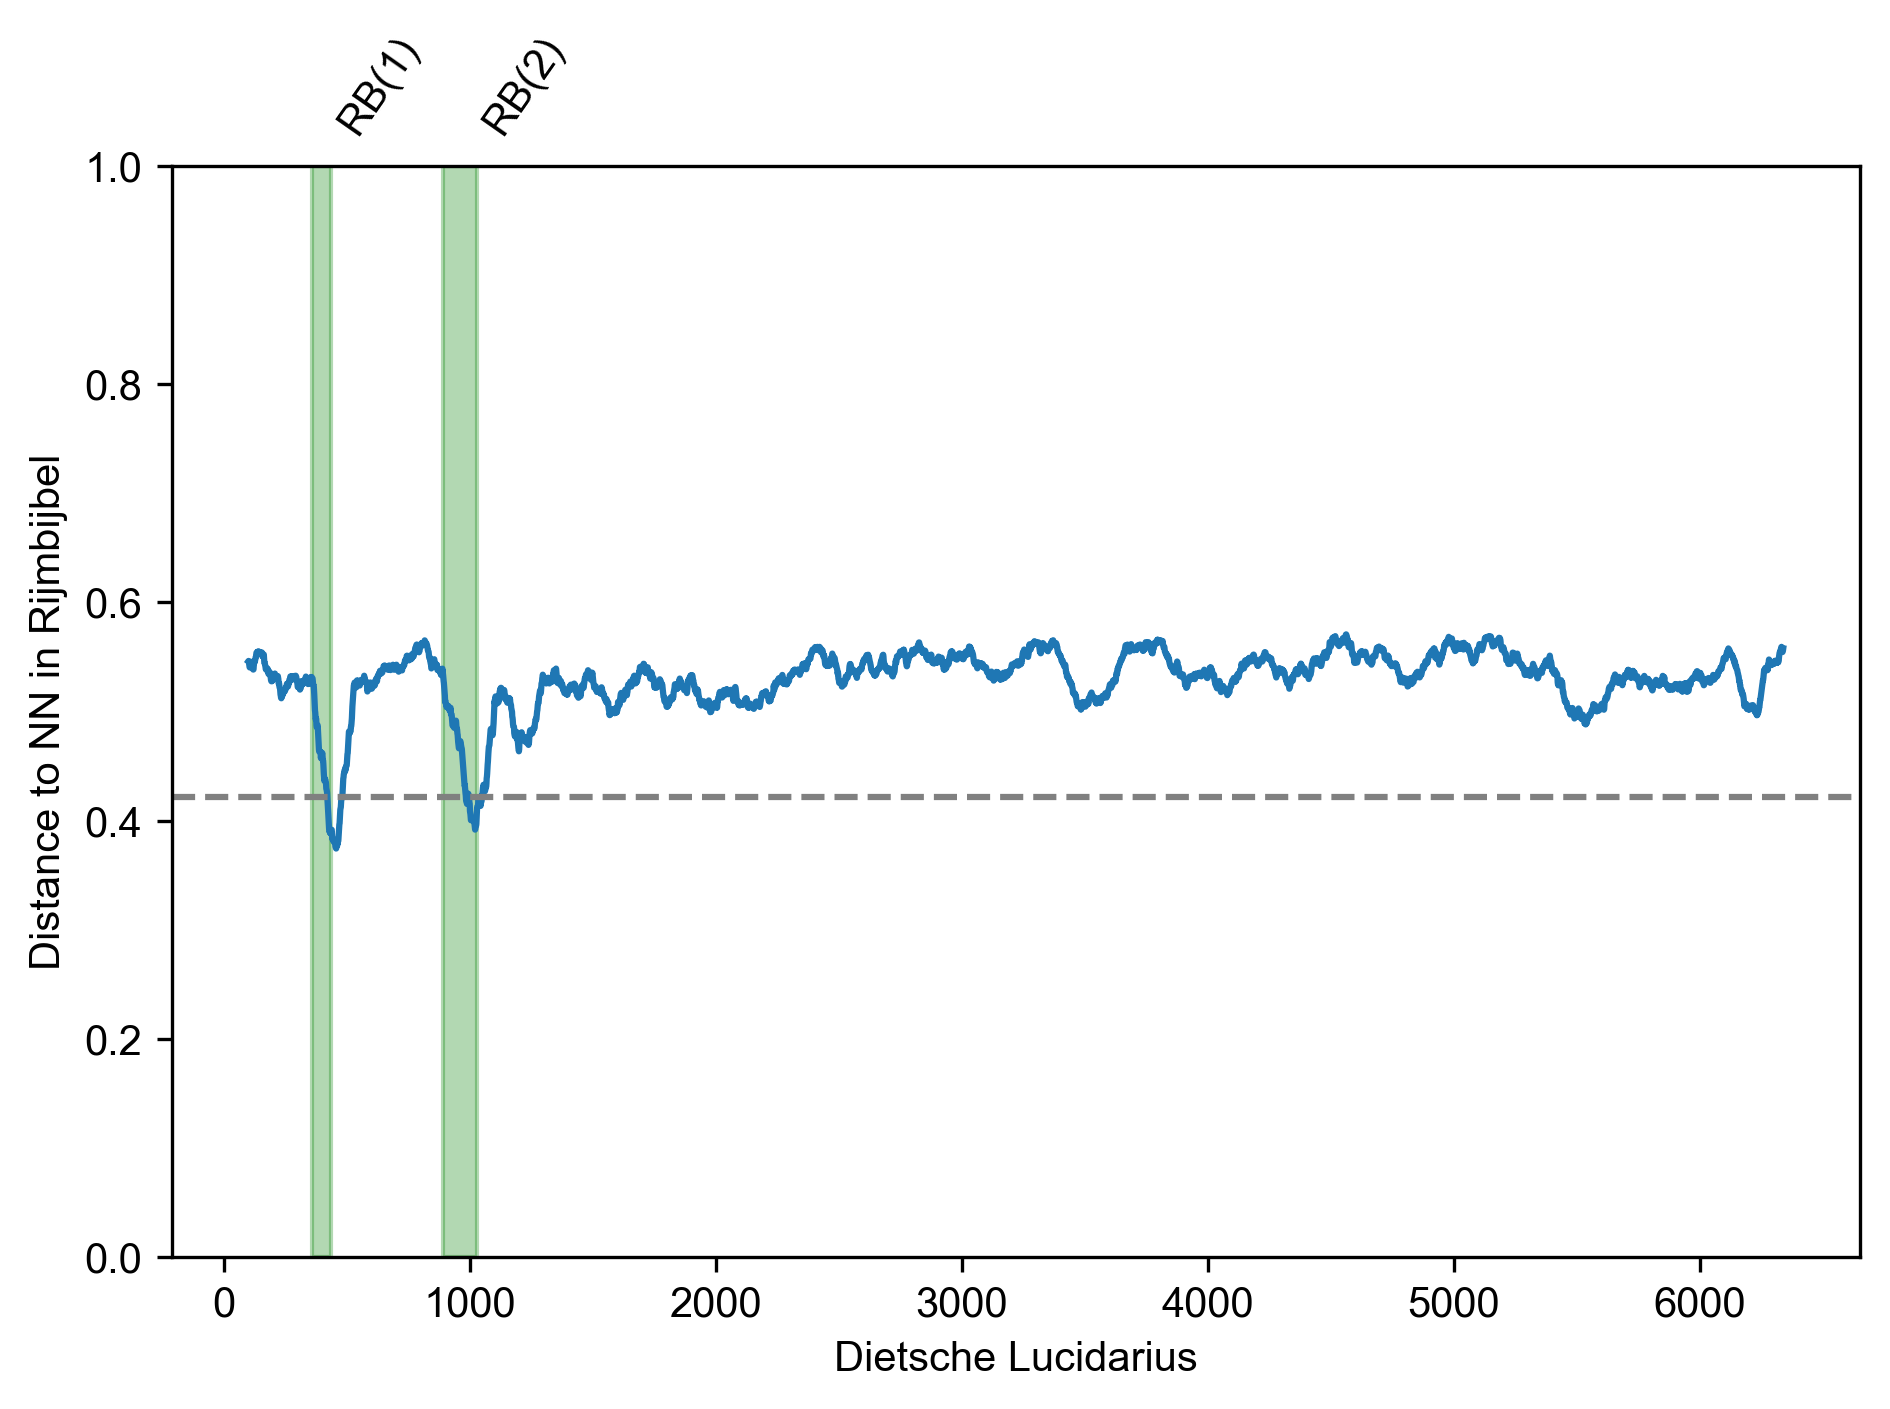

In [18]:
t1, t2 = 'Dietsche Lucidarius', 'Rijmbijbel'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=optim_th, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    if not 'SpHist' in n:
        ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
        plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()

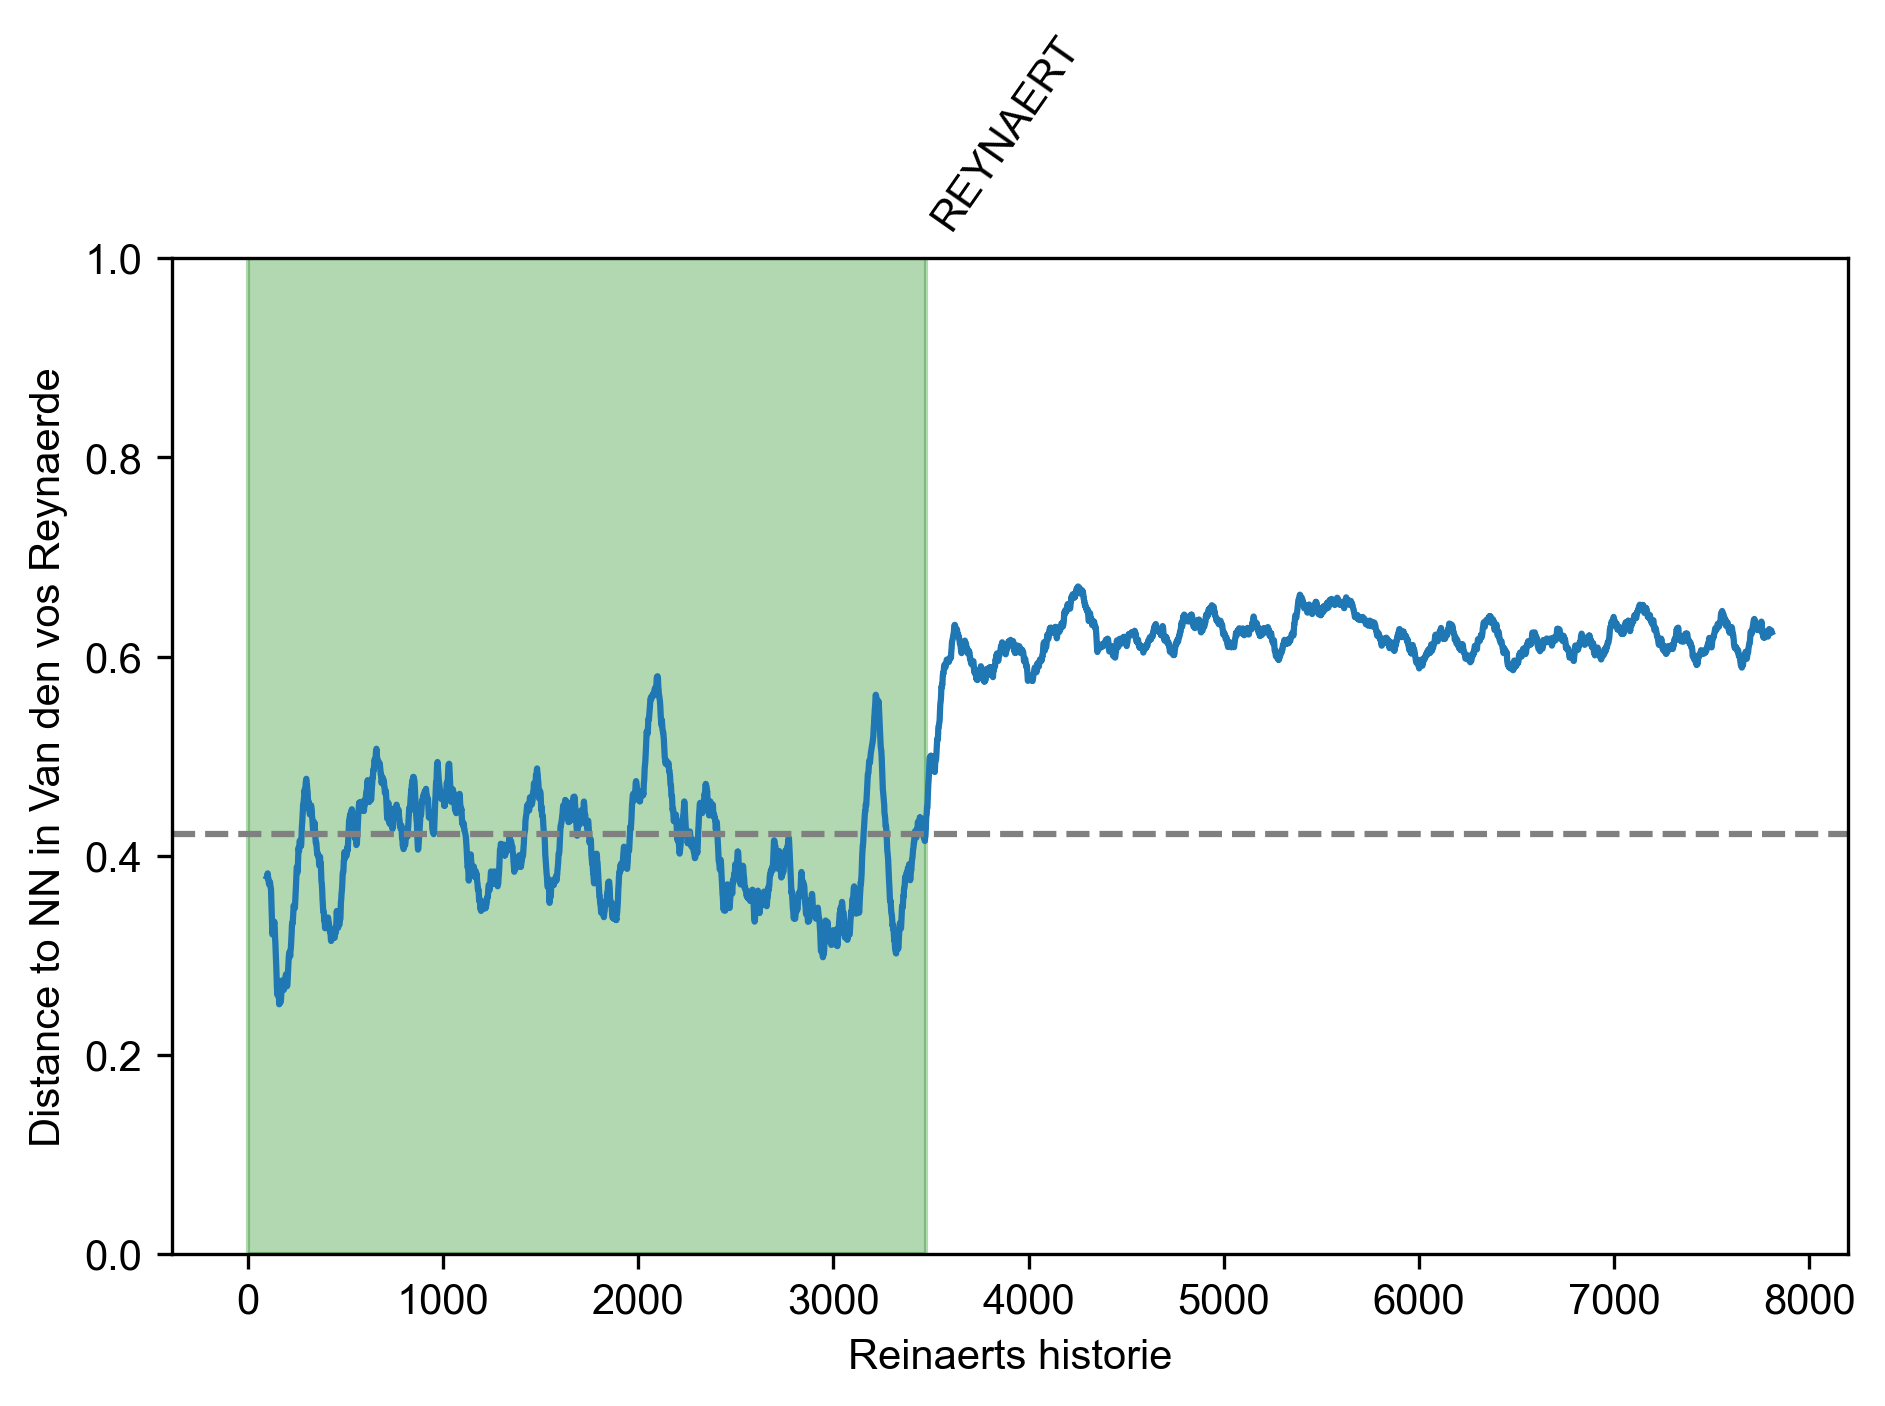

In [19]:
t1, t2 = 'Reinaerts historie', 'Van den vos Reynaerde'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=optim_th, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    if not 'gebed' in n:
        ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
        plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()